# Task 2. Analysis of sellers and products 
In this block, I would like to see the analytics of sellers and products that are placed on our marketplace. You are provided with the data: sellers, products - based on them, you need to build an analytical report that includes: the most/least turnover sellers, leaders/outsiders in sales in each area. As for products, we are interested in analytics on turnover, which products sell best in each category, as well as the dependence of product weight on turnover and price. It is also interesting to see the segmentation of sellers and products with textual conclusions about the business value of using these results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from prepare import *

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

# Data loading:

In [3]:
data_dir = 'S_Data/'
dicts_dir = 'S_Data/dicts/'

data = get_data(data_dir)
dicts = get_data(dicts_dir, sep=';')

In [4]:
df_sellers = data['sellers']
df_products = data['products']
df_orders = data['orders']
df_payments = data['order_payments']
df_order_items = data['order_items']
df_cat_translate = data['product_category_name_translation']

# Solution:

## 1. The most/least turnover sellers
Usually, on marketplaces, buyers pay for delivery to the delivery company. Therefore, when calculating turnover, we will not take into account the cost of delivery, although it is better to check with the client about the specifics of the marketplace's operation.

In [6]:
print("Unique sellers number: ", len(df_order_items['seller_id'].unique()))

Unique sellers number:  3095


In [7]:
payed_orders_ids = df_payments['order_id'].unique()
sellers_prices = df_order_items[df_order_items['order_id'].isin(payed_orders_ids)][['seller_id', 'price']]
sellers_prices = sellers_prices.groupby('seller_id').apply(sum).drop('seller_id', axis=1).reset_index()
sellers_prices.head()

,seller_id,price
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03
2,001e6ad469a905060d959994f1b41e4f,250.00
3,002100f778ceb8431b7a1020ff7ab48f,1234.50
4,003554e2dce176b5555353e4f3555ac8,120.00


In [8]:
top_10_most = sellers_prices.sort_values(by='price', ascending=False).head(10)
most_dict = dict(zip(range(1, 11), list(top_10_most['seller_id'])))

In [9]:
top_10_least = sellers_prices.sort_values(by='price', ascending=True).head(10)
least_dict = dict(zip(range(1, 11), list(top_10_least['seller_id'])))

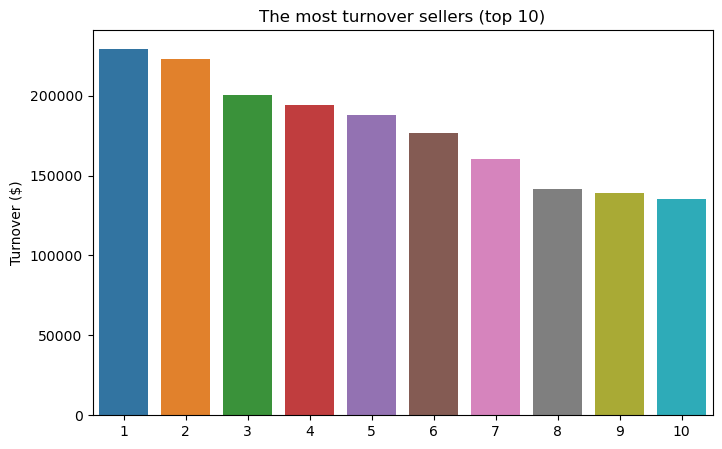

=================== Sellers ids: ===================


,seller_id
1,4869f7a5dfa277a7dca6462dcf3b52b2
2,53243585a1d6dc2643021fd1853d8905
3,4a3ca9315b744ce9f8e9374361493884
4,fa1c13f2614d7b5c4749cbc52fecda94
5,7c67e1448b00f6e969d365cea6b010ab
6,7e93a43ef30c4f03f38b393420bc753a
7,da8622b14eb17ae2831f4ac5b9dab84a
8,7a67c85e85bb2ce8582c35f2203ad736
9,1025f0e2d44d7041d6cf58b6550e0bfa
10,955fee9216a65b617aa5c0531780ce60


In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=top_10_most, x=[str(x) for x in range(1, 11)], y='price', palette='tab10')
plt.title("The most turnover sellers (top 10)")
plt.ylabel("Turnover ($)")
plt.show()

print("=================== Sellers ids: ===================")
pd.DataFrame({'seller_id': most_dict.values()}, index=most_dict.keys())

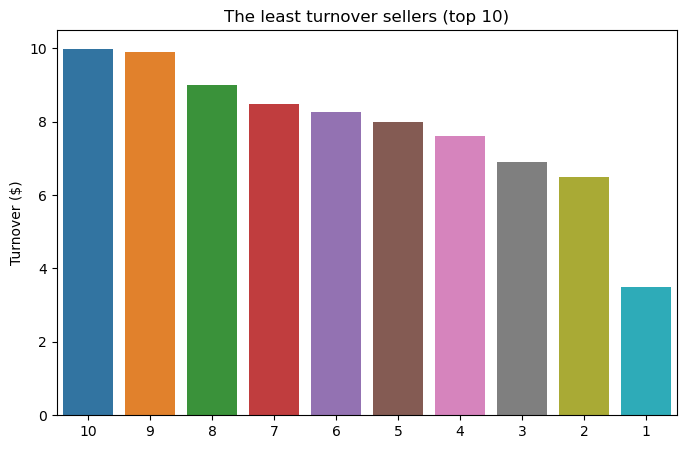

=================== Sellers ids: ===================


,seller_id
1,cf6f6bc4df3999b9c6440f124fb2f687
2,77128dec4bec4878c37ab7d6169d6f26
3,1fa2d3def6adfa70e58c276bb64fe5bb
4,702835e4b785b67a084280efca355756
5,34aefe746cd81b7f3b23253ea28bef39
6,ad14615bdd492b01b0d97922e87cb87f
7,4965a7002cca77301c82d3f91b82e1a9
8,0f94588695d71662beec8d883ffacf09
9,c18309219e789960add0b2255ca4b091
10,95cca791657aabeff15a07eb152d7841


In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(x=[str(x) for x in reversed(range(1, 11))], y=top_10_least.sort_values('price', ascending=False)['price'], palette='tab10')
plt.title("The least turnover sellers (top 10)")
plt.ylabel("Turnover ($)")
plt.show()

print("=================== Sellers ids: ===================")
pd.DataFrame({'seller_id': least_dict.values()}, index=least_dict.keys())

We do not have specific names of sellers or company names, so for each of the two charts there is a list of identifiers, which can be useful if we have a complete database with a lot of information about sellers.

Overall we can see that we have sellers with over `$200000` in sales and there are (most likely newcomers to the market) with under `$10` in sales. Some more specific and useful information is not presented in this block.

## 2. Leaders/Outsiders in sales in each area
As we know from the previous task, we have 74 different product categories. There are probably some very unpopular categories, which can be neglected, because I think it is unnecessary to separate leaders and outsiders in each category regardless of its popularity. The popularity of categories will be measured in the number of orders for the goods of each particular category.

First of all, let's look at the number of orders in each category:

In [12]:
order_items = df_order_items[df_order_items['order_id'].isin(payed_orders_ids)]
product_category_dict = dict(zip(list(df_products['product_id']), list(df_products['product_category_name'])))
order_items['category'] = order_items['product_id'].apply(lambda x: product_category_dict[str(x)])

In [13]:
temp_prod_cat = order_items[['category']]
temp_prod_cat['num_orders'] = np.ones(len(temp_prod_cat))
temp_prod_cat = temp_prod_cat.groupby('category').apply(sum).drop('category', axis=1).reset_index()

In [14]:
category_eng_dict = dict(zip(list(df_cat_translate['product_category_name']), list(df_cat_translate['product_category_name_english'])))
temp_prod_cat['eng_category'] = temp_prod_cat['category'].apply(lambda x: category_eng_dict[str(x)] if x in category_eng_dict.keys() else str(x))

In [15]:
temp_prod_cat['num_orders'].describe()

count       73.000000
mean      1521.150685
std       2582.581577
min          2.000000
25%         76.000000
50%        278.000000
75%       1691.000000
max      11115.000000
Name: num_orders, dtype: float64

In [16]:
temp_prod_cat['num_orders'].quantile(0.71)

948.5599999999996

As we can see, most of the categories are not very popular. For further analysis, we will take values greater than 1000, so as not to waste time on a huge number of unpopular categories.

In [17]:
print("Amount of categories we will analyse: ", len(temp_prod_cat[temp_prod_cat['num_orders'] >= 1000]))

Amount of categories we will analyse:  21


In [18]:
new_category_list = temp_prod_cat[temp_prod_cat['num_orders'] >= 1000]

In [19]:
order_items_final = order_items[order_items['category'].isin(list(new_category_list['category']))][['seller_id', 'category']]
order_items_final['num_orders'] = np.ones(len(order_items_final))

In [20]:
df = []
categories = list(new_category_list['category'])
    
for category in categories:
    temp = order_items_final[order_items_final['category'] == str(category)]
    temp.drop('category', axis=1, inplace=True)
    temp = temp.groupby('seller_id').apply(sum)
    temp.drop('seller_id', axis=1, inplace=True)
    temp.reset_index(inplace=True)
    df.append(temp)

In [21]:
df_leaders = []
df_outsiders = []
    
for dataframe in df:
    temp = dataframe.sort_values('num_orders', ascending=False)
    df_leaders.append(temp)
    df_outsiders.append(temp.iloc[::-1])

In [22]:
categories = list(new_category_list['eng_category'])

In [23]:
for dset in [df_leaders, df_outsiders]:
    for df in dset:
        total_share = sum(df['num_orders'])
        df['percent_share'] = df['num_orders'].apply(lambda x: 100*x/total_share)

Finally, let's move on to the graph! Let's draw it in the form of a horizontal barplot, where we can clearly see the shares of sales that fall on each particular seller in each of the selected categories:

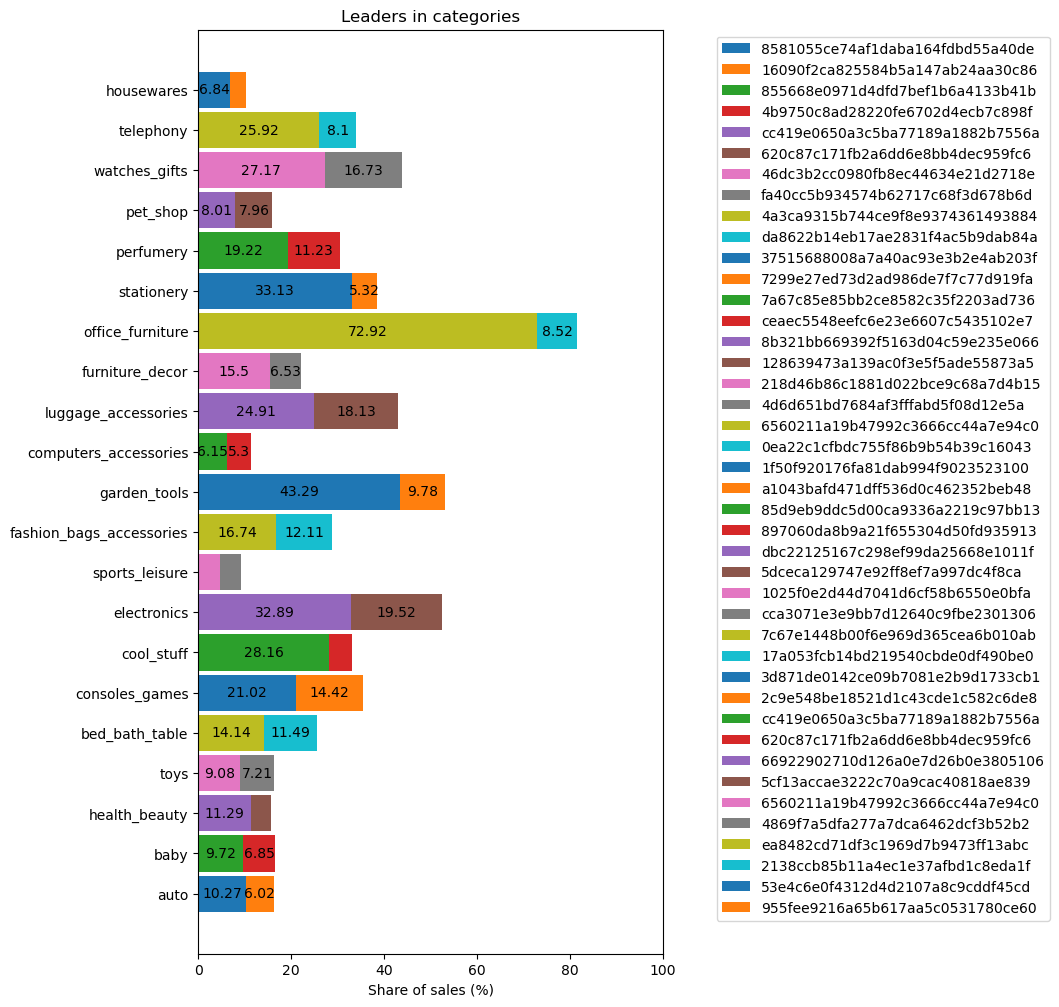

In [24]:
fig, ax = plt.subplots(figsize=(6, 12))

for index, df in enumerate(df_leaders):
    bar_values = [0 for i in range(len(categories))]
    
    num_parts = 1 if df.iloc[0]['percent_share'] >= 80 else 2
    #num_parts = 5
        
    sum_share = 0
    
    for i in range(num_parts):
        share = df.iloc[i]['percent_share']
        bar_values[index] = share
        p = ax.barh(categories, bar_values, 0.9, label=df.iloc[i]['seller_id'], left=sum_share)
        bar_labels = [float('%.2f' % val) if val > 5 else '' for val in bar_values]
        ax.bar_label(p, labels=bar_labels, label_type='center')
        sum_share += share
    
    ax.legend(bbox_to_anchor=(1.1, 1.0))
    ax.set_xlim([0, 100])
    ax.set_xlabel("Share of sales (%)")
    ax.set_title("Leaders in categories")

The graph was not informative at all, and as it turned out, the most successful format for visual analytics of leaders and outsiders in case of such a large number of sellers and categories is simple tables. Therefore, I will leave here a tool for quick access to the leaders and their indices of each specific category:

In [25]:
print("Possible categories titles: ")
categories

Possible categories titles: 


['auto',
 'baby',
 'health_beauty',
 'toys',
 'bed_bath_table',
 'consoles_games',
 'cool_stuff',
 'electronics',
 'sports_leisure',
 'fashion_bags_accessories',
 'garden_tools',
 'computers_accessories',
 'luggage_accessories',
 'furniture_decor',
 'office_furniture',
 'stationery',
 'perfumery',
 'pet_shop',
 'watches_gifts',
 'telephony',
 'housewares']

In [26]:
print("==================== Leaders of categories ====================")
category = input("Enter the title of category (eng): ")
if category not in categories:
    print("Incorrect title of category!")
else:
    print("Top 10 sellers in this category: ")
    display(df_leaders[categories.index(category)].head(10))

==================== Leaders of categories ====================
Enter the title of category (eng): housewares
Top 10 sellers in this category: 


,seller_id,num_orders,percent_share
141,53e4c6e0f4312d4d2107a8c9cddf45cd,476.0,6.835152
268,955fee9216a65b617aa5c0531780ce60,242.0,3.475014
237,813348c996469b40f2e028d5429d3495,202.0,2.900632
275,98dac6635aee4995d501a3972e047414,195.0,2.800115
452,f8db351d8c4c4c22c6835c19a46f01b0,189.0,2.713957
356,ca3bd7cd9f149df75950150d010fe4a2,134.0,1.924182
123,4830e40640734fc1c52cd21127c341d4,123.0,1.766226
463,febab0275244b9a49a623f0bd613ca2f,123.0,1.766226
17,0adac9fbd9a2b63cccaac4f8756c1ca8,114.0,1.636990
252,8e6cc767478edae941d9bd9eb778d77a,113.0,1.622631


And the exact same mini-tool for outsiders:

In [27]:
print("=================== Outsiders of categories ===================")
category = input("Enter the title of category (eng): ")
if category not in categories:
    print("Incorrect title of category!")
else:
    print("Anti-top 10 sellers in this category: ")
    display(df_outsiders[categories.index(category)].head(10))

=================== Outsiders of categories ===================
Enter the title of category (eng): auto
Anti-top 10 sellers in this category: 


,seller_id,num_orders,percent_share
191,7c1fea10b5b006671d608b1d7c446ec4,1.0,0.023613
273,b2f4d63c7203f539a78252565ca32257,1.0,0.023613
106,455c5640e8c5bd1b2ee85c0158f85727,1.0,0.023613
269,b0398568231ba5e6734af1881671a317,1.0,0.023613
267,ad14615bdd492b01b0d97922e87cb87f,1.0,0.023613
109,466222e777149751370e7e98fb623b0c,1.0,0.023613
265,acadd4d36859671cb635527c6c977533,1.0,0.023613
113,4869f7a5dfa277a7dca6462dcf3b52b2,1.0,0.023613
262,a9ae440659f48b7849df83e82734150b,1.0,0.023613
258,a67780aba9dd436e7ac0aa1f889e73ec,1.0,0.023613


## 3. Products are sold the best in each category
We will measure the saleability of a product in the number of orders for that product, and we will also look at the turnover of each product:

In [28]:
categories = list(new_category_list['category'])
eng_categories = list(new_category_list['eng_category'])

In [29]:
order_items_3 = order_items[['product_id', 'price', 'category']]
order_items_3 = order_items_3[order_items_3['category'].isin(categories)]
order_items_3['num_orders'] = np.ones(len(order_items_3))
order_items_3.head()

,product_id,price,category,num_orders
0,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff,1.0
1,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop,1.0
2,c777355d18b72b67abbeef9df44fd0fd,199.00,moveis_decoracao,1.0
3,7634da152a4610f1595efa32f14722fc,12.99,perfumaria,1.0
4,ac6c3623068f30de03045865e4e10089,199.90,ferramentas_jardim,1.0


In [30]:
dfs = []

for category in categories:
    temp_df = order_items_3[order_items_3['category'] == str(category)]
    temp_df = temp_df.drop('category', axis=1).groupby('product_id').apply(sum)
    num_orders_total = sum(temp_df['num_orders'])
    temp_df['num_orders (%)'] = temp_df['num_orders'].apply(lambda x: 100*x/num_orders_total)
    temp_df['turnover'] = temp_df['price']
    
    temp_df.drop(['product_id', 'price'], axis=1, inplace=True)
    temp_df.reset_index(inplace=True)
    
    turnover_total = sum(temp_df['turnover'])
    temp_df['turnover (%)'] = temp_df['turnover'].apply(lambda x: 100*x/turnover_total)
    dfs.append(temp_df)

In [32]:
cat = input("Enter thee category title: ")
if cat in eng_categories:
    sort_by = input("Enter the target (0 - turnover, 1 - amount of orders): ")
    sort_by = '0' if sort_by not in ['0', '1'] else sort_by
        
    sort_dict = {'0': 'turnover', '1': 'num_orders'}
    index = eng_categories.index(cat)

    print("================ Top 10 products of", cat, "category by", sort_dict[sort_by], "================")
    display(dfs[index].sort_values(by=sort_dict[sort_by], ascending=False).head(10))
else:
    print("Incorrect category title!")

Enter thee category title: office_furniture
Enter the target (0 - turnover, 1 - amount of orders): 1
================ Top 10 products of office_furniture category by num_orders ================


,product_id,num_orders,num_orders (%),turnover,turnover (%)
182,8ed094bfe076c568f6bb10feada3f75d,70.0,4.139562,12947.09,4.725893
89,3eef0cb94ba82de806bb30ab743c7655,59.0,3.489060,4739.41,1.729960
217,a9516a079e37a9c9c36b9b78b10169e8,59.0,3.489060,7042.41,2.570591
219,aba86c093ccdbac75b09111d57e50004,57.0,3.370787,6819.20,2.489116
58,2a5806f10d0f00e5ad032dd2e3c8806e,55.0,3.252513,9421.45,3.438979
226,b114bf337c0626166abe574eee9e3f32,54.0,3.193377,8348.00,3.047152
40,1bfb290d7273a442c874dbe74b4abae6,46.0,2.720284,3553.24,1.296989
60,2b7aa376a6e728560bddb5558cc48e89,33.0,1.951508,3857.67,1.408111
266,d6fe3b4ddecd4a8393c6a1385de3bfb6,31.0,1.833235,6160.17,2.248560
239,b92a7304ebad1ca5b393b53b2de5c70a,30.0,1.774098,4238.66,1.547178


I couldn't think of anything better than to reintroduce simple spreadsheets to view turnover and order quantity (number and percentage). This is the easiest and most reliable way, as it is not possible to fit it all into a graph.

## 4. Dependence of product weight on turnover and price

In [33]:
products_prices = df_order_items[df_order_items['order_id'].isin(payed_orders_ids)][['product_id', 'price']]
products_prices_mean = products_prices.groupby('product_id').apply(np.mean)
products_turnover = products_prices.groupby('product_id').apply(sum).drop('product_id', axis=1)
products_turnover['turnover'] = products_turnover['price']
products_turnover.drop('price', axis=1, inplace=True)
products_prices['num_orders'] = np.ones(len(products_prices))
products_orders = products_prices[['product_id', 'num_orders']].groupby('product_id').apply(sum).drop('product_id', axis=1)

In [34]:
products_weights_dict = dict(zip(list(df_products['product_id']), list(df_products['product_weight_g'])))
products_turnover_dict = dict(zip(products_turnover.index, list(products_turnover['turnover'])))
products_prices_dict = dict(zip(products_prices_mean.index, list(products_prices_mean['price'])))
products_orders_dict = dict(zip(products_orders.index, list(products_orders['num_orders'])))

In [35]:
unique_products_ids = products_turnover.index

In [36]:
products_wtp = pd.DataFrame({'product_id': unique_products_ids})
products_wtp['price'] = products_wtp['product_id'].apply(lambda x: products_prices_dict[str(x)])
products_wtp['turnover'] = products_wtp['product_id'].apply(lambda x: products_turnover_dict[str(x)])
products_wtp['weight'] = products_wtp['product_id'].apply(lambda x: products_weights_dict[str(x)])
products_wtp['num_orders'] = products_wtp['product_id'].apply(lambda x: products_orders_dict[str(x)])

In [37]:
products_wtp['weight_kg'] = products_wtp['weight'].apply(lambda x: x/1000)
products_wtp

,product_id,price,turnover,weight,num_orders,weight_kg
0,00066f42aeeb9f3007548bb9d3f33c38,101.65,101.65,300.0,1.0,0.300
1,00088930e925c41fd95ebfe695fd2655,129.90,129.90,1225.0,1.0,1.225
2,0009406fd7479715e4bef61dd91f2462,229.00,229.00,300.0,1.0,0.300
3,000b8f95fcb9e0096488278317764d19,58.90,117.80,550.0,2.0,0.550
4,000d9be29b5207b54e86aa1b1ac54872,199.00,199.00,250.0,1.0,0.250
...,...,...,...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,114.99,229.98,1400.0,2.0,1.400
32947,fff81cc3158d2725c0655ab9ba0f712c,90.00,90.00,58.0,1.0,0.058
32948,fff9553ac224cec9d15d49f5a263411f,32.00,32.00,150.0,1.0,0.150
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,33.99,169.95,150.0,5.0,0.150


Now let's build graphs that will clearly show the dependencies between turnover and weight of goods, price and weight of goods:

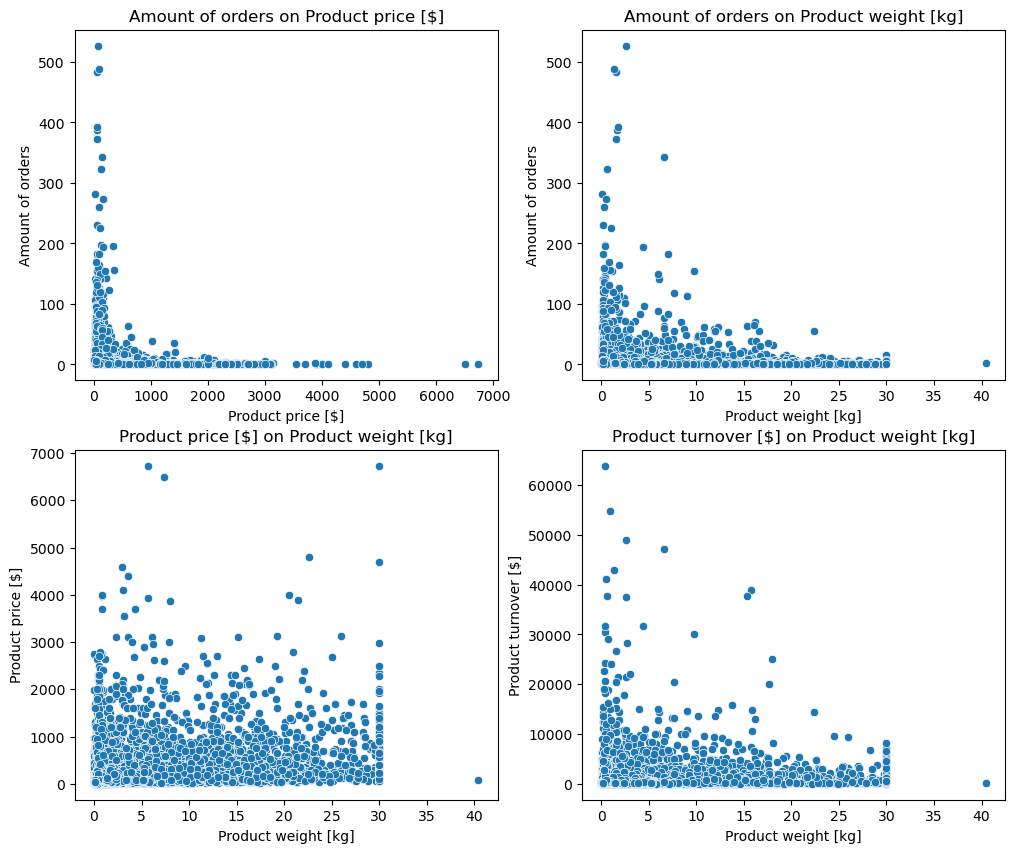

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dependencies = [['num_orders', 'price'],
                ['num_orders', 'weight_kg'],
                ['price', 'weight_kg'],
                ['turnover', 'weight_kg']]
titles = {
    'num_orders': 'Amount of orders',
    'weight_kg': 'Product weight [kg]',
    'price': 'Product price [$]',
    'turnover': 'Product turnover [$]'
}

for index, ax in enumerate(axs.flatten()):
    vars_ = dependencies[index]
    sns.scatterplot(data=products_wtp, x=vars_[1], y=vars_[0], ax=ax)
    ax.set_xlabel(titles[vars_[1]])
    ax.set_ylabel(titles[vars_[0]])
    ax.set_title(titles[vars_[0]] + " on " + titles[vars_[1]])
    
#fig.tight_layout()

Let's break down these graphs:
1. Dependence of the number of orders on the price:
   You can see that goods with a low price are ordered much more often, and as the price increases, the number of orders falls. This is quite logical.
    
2. Dependence of the number of orders on the weight of goods:
   Here is approximately the same situation as in the previous point. As the weight of the product increases, the number of orders falls.
    
3. Dependence of product price on its weight:
   There are no clear trends here and the distribution is close to uniform with some outliers along the entire axis of product weight.
    
4. Dependence of turnover on product weight:
   Turnover is directly related to price and order quantity. Therefore, this graph is something in between the graphs of price-weight dependence and order quantity-weight dependence. There is a correlation between turnover and product weight. Since we have already found out that products with a smaller weight are ordered more times than those with a larger weight, and turnover depends on the number of orders, it also depends on the weight of the product, but this dependence is less strict than in the case of the number of orders, because the price also affects.

# Conclusions
In general, based on the information obtained during this assignment, we can say that the above graphs and analytics can help to better understand the characteristics of products and sellers: who gets the most orders in each category and who gets the least. This information can be useful not only for marketplace owners, but also for its users. Such statistics can be displayed, for example, in the user's personal cabinet to make it easier for him to orient himself when buying or selling a product. It should also be taken into account that the analysis was not conducted for all categories (there are too many to consider each), and if necessary, you can get all the same metrics and graphs for the categories of goods that were not included in the consideration.